<a href="https://colab.research.google.com/github/tushar-semwal/fedperf/blob/main/Vineeth/FedAvg_Shakesphere_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummaryX unidecode

     |████████████████████████████████| 245kB 8.4MB/s 


In [2]:
%%capture output
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    path = '/content/drive/MyDrive/Colab Notebooks/OpenMined/'
    os.makedirs(path, exist_ok=True)
except:
    path = './'

## Imports

In [3]:
%load_ext tensorboard

import copy
from functools import reduce
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchsummaryX import summary as summaryx
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
from unidecode import unidecode

%matplotlib inline

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
RANDOM_SEED = 42

# general reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Sun Apr 25 03:40:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the Shakesphere Dataset

In [9]:
!rm -Rf data
!mkdir -p data scripts

In [10]:
GENERATE_DATASET = False  # If False, download the dataset provided by the q-FFL paper
DATA_DIR = 'data/'
# Dataset generation params
SAMPLES_FRACTION = 1.  # If using an already generated dataset
# SAMPLES_FRACTION = 0.2  # Fraction of total samples in the dataset - FedProx default script
# SAMPLES_FRACTION = 0.05  # Fraction of total samples in the dataset - qFFL
TRAIN_FRACTION = 0.8  # Train set size
MIN_SAMPLES = 0  # Min samples per client (for filtering purposes) - FedProx
# MIN_SAMPLES = 64  # Min samples per client (for filtering purposes) - qFFL

In [11]:
# Download raw dataset
# !wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt -O data/shakespeare.txt
!wget --adjust-extension http://www.gutenberg.org/files/100/100-0.txt -O data/shakespeare.txt

--2021-04-25 03:41:42--  http://www.gutenberg.org/files/100/100-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5757108 (5.5M) [text/plain]
Saving to: ‘data/shakespeare.txt’

data/shakespeare.tx 100%[===================>]   5.49M  3.40MB/s    in 1.6s    

2021-04-25 03:41:44 (3.40 MB/s) - ‘data/shakespeare.txt’ saved [5757108/5757108]



In [12]:
if not GENERATE_DATASET:
    !rm -Rf data/train data/test
    !gdown --id 1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD  # Download Shakespeare dataset used by the FedProx paper
    !unzip shakespeare.zip
    !mv -f shakespeare_paper/train data/
    !mv -f shakespeare_paper/test data/
    !rm -R shakespeare_paper/ shakespeare.zip


Downloading...
From: https://drive.google.com/uc?id=1n46Mftp3_ahRi1Z6jYhEriyLtdRDS1tD
To: /content/shakespeare.zip
2.96MB [00:00, 94.6MB/s]
Archive:  shakespeare.zip
   creating: shakespeare_paper/
   creating: shakespeare_paper/test/
  inflating: shakespeare_paper/test/all_data_niid_2_keep_0_test_8.json  
   creating: shakespeare_paper/train/
  inflating: shakespeare_paper/train/all_data_niid_2_keep_0_train_8.json  


In [13]:
corpus = []
with open('data/shakespeare.txt', 'r') as f:
    data = list(unidecode(f.read()))
    corpus = list(set(list(data)))
print('Corpus Length:', len(corpus))

Corpus Length: 90


#### Dataset Preprocessing script

In [14]:
%%capture
if GENERATE_DATASET:
    # Download dataset generation scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/preprocess_shakespeare.py -O scripts/preprocess_shakespeare.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/shake_utils.py -O scripts/shake_utils.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/data/shakespeare/preprocess/gen_all_data.py -O scripts/gen_all_data.py

    # Download data preprocessing scripts
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/sample.py -O scripts/sample.py
    !wget https://raw.githubusercontent.com/ml-lab/FedProx/master/utils/remove_users.py -O scripts/remove_users.py

In [15]:
# Running scripts
if GENERATE_DATASET:
    !mkdir -p data/raw_data data/all_data data/train data/test
    !python scripts/preprocess_shakespeare.py data/shakespeare.txt data/raw_data
    !python scripts/gen_all_data.py

#### Dataset class

In [16]:
class ShakespeareDataset(Dataset):
    def __init__(self, x, y, corpus, seq_length):
        self.x = x
        self.y = y
        self.corpus = corpus
        self.corpus_size = len(self.corpus)
        super(ShakespeareDataset, self).__init__()

    def __len__(self):
        return len(self.x)

    def __repr__(self):
        return f'{self.__class__} - (length: {self.__len__()})'

    def __getitem__(self, i):
        input_seq = self.x[i]
        next_char = self.y[i]
        # print('\tgetitem', i, input_seq, next_char)
        input_value = self.text2charindxs(input_seq)
        target_value = self.get_label_from_char(next_char)
        return input_value, target_value

    def text2charindxs(self, text):
        tensor = torch.zeros(len(text), dtype=torch.int32)
        for i, c in enumerate(text):
            tensor[i] = self.get_label_from_char(c)
        return tensor

    def get_label_from_char(self, c):
        return self.corpus.index(c)

    def get_char_from_label(self, l):
        return self.corpus[l]

##### Federated Dataset

In [17]:
class ShakespeareFedDataset(ShakespeareDataset):
    def __init__(self, x, y, corpus, seq_length):
        super(ShakespeareFedDataset, self).__init__(x, y, corpus, seq_length)

    def dataloader(self, batch_size, shuffle=True):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=0)


## Partitioning & Data Loaders

### IID

In [18]:
def iid_partition_(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [19]:
def iid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_train, y_train = [], []
    x_test, y_test = [], []
    # x_val, y_val = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)



    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train.extend(data_train['user_data'][author_id]['x'][:max_samples])
            y_train.extend(data_train['user_data'][author_id]['y'][:max_samples])

            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)

            if val_split:
                x_test.extend(author_data['x'][:int(test_size / 2)])
                y_test.extend(author_data['y'][:int(test_size / 2)])
                # x_val.extend(author_data['x'][int(test_size / 2):])
                # y_val.extend(author_data['y'][int(test_size / 2):int(test_size)])

            else:
                x_test.extend(author_data['x'][:int(test_size)])
                y_test.extend(author_data['y'][:int(test_size)])

    train_ds = ShakespeareDataset(x_train, y_train, corpus, seq_length)
    test_ds = ShakespeareDataset(x_test, y_test, corpus, seq_length)
    # val_ds = ShakespeareDataset(x_val, y_val, corpus, seq_length)

    data_dict = iid_partition_(train_ds, clients=len(users))

    return train_ds, data_dict, test_ds

### Non-IID

In [20]:
def noniid_partition(corpus, seq_length=80, val_split=False):

    train_file = [os.path.join(DATA_DIR, 'train', f) for f in os.listdir(f'{DATA_DIR}/train') if f.endswith('.json')][0]
    test_file = [os.path.join(DATA_DIR, 'test', f) for f in os.listdir(f'{DATA_DIR}/test') if f.endswith('.json')][0]

    with open(train_file, 'r') as file:
        data_train = json.loads(unidecode(file.read()))

    with open(test_file, 'r') as file:
        data_test = json.loads(unidecode(file.read()))

    
    total_samples_train = sum(data_train['num_samples'])

    data_dict = {}

    x_test, y_test = [], []

    users = list(zip(data_train['users'], data_train['num_samples']))
    # random.shuffle(users)

    total_samples = int(sum(data_train['num_samples']) * SAMPLES_FRACTION)
    print('Objective', total_samples, '/', sum(data_train['num_samples']))
    sample_count = 0
    
    for i, (author_id, samples) in enumerate(users):

        if sample_count >= total_samples:
            print('Max samples reached', sample_count, '/', total_samples)
            break

        if samples < MIN_SAMPLES: # or data_train['num_samples'][i] > 10000:
            print('SKIP', author_id, samples)
            continue
        else:
            udata_train = data_train['user_data'][author_id]
            max_samples = samples if (sample_count + samples) <= total_samples else (sample_count + samples - total_samples) 
            
            sample_count += max_samples
            # print('sample_count', sample_count)

            x_train = data_train['user_data'][author_id]['x'][:max_samples]
            y_train = data_train['user_data'][author_id]['y'][:max_samples]

            train_ds = ShakespeareFedDataset(x_train, y_train, corpus, seq_length)

            x_val, y_val = None, None
            val_ds = None
            author_data = data_test['user_data'][author_id]
            test_size = int(len(author_data['x']) * SAMPLES_FRACTION)
            if val_split:
                x_test += author_data['x'][:int(test_size / 2)]
                y_test += author_data['y'][:int(test_size / 2)]
                x_val = author_data['x'][int(test_size / 2):]
                y_val = author_data['y'][int(test_size / 2):int(test_size)]

                val_ds = ShakespeareFedDataset(x_val, y_val, corpus, seq_length)

            else:
                x_test += author_data['x'][:int(test_size)]
                y_test += author_data['y'][:int(test_size)]

            data_dict[author_id] = {
                'train_ds': train_ds,
                'val_ds': val_ds
            }

    test_ds = ShakespeareFedDataset(x_test, y_test, corpus, seq_length)

    return data_dict, test_ds

## Models

### Shakespeare LSTM

In [21]:
class ShakespeareLSTM(nn.Module):
    """
    """

    def __init__(self, input_dim, embedding_dim, hidden_dim, classes, lstm_layers=2, dropout=0.1, batch_first=True):
        super(ShakespeareLSTM, self).__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.classes = classes
        self.no_layers = lstm_layers
        
        self.embedding = nn.Embedding(num_embeddings=self.classes,
                                      embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim,
                            num_layers=self.no_layers,
                            batch_first=batch_first, 
                            dropout=dropout if self.no_layers > 1 else 0.)
        self.fc = nn.Linear(hidden_dim, self.classes)

    def forward(self, x, hc=None):
        batch_size = x.size(0)
        x_emb = self.embedding(x)
        out, (ht, ct) = self.lstm(x_emb.view(batch_size, -1, self.embedding_dim), hc)
        dense = self.fc(ht[-1])
        return dense
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)),
                Variable(torch.zeros(self.no_layers, batch_size, self.hidden_dim)))


#### Model Summary

In [22]:
batch_size = 10
seq_length = 80 # mcmahan17a, fedprox, qFFL

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=8,  # mcmahan17a, fedprox, qFFL
                                   hidden_dim=256,  # mcmahan17a, fedprox impl
                                #    hidden_dim=100,  # fedprox paper
                                   classes=len(corpus),
                                   lstm_layers=2,
                                   dropout=0.1,  # TODO:
                                   batch_first=True
                                   )

if torch.cuda.is_available():
  shakespeare_lstm.cuda()



hc = shakespeare_lstm.init_hidden(batch_size)

x_sample = torch.zeros((batch_size, seq_length),
                       dtype=torch.long,
                       device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')))

x_sample[0][0] = 1
x_sample

print("\nShakespeare LSTM SUMMARY")
print(summaryx(shakespeare_lstm, x_sample))


Shakespeare LSTM SUMMARY
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040
----------------------------------------------------------
                      Totals
Total params          822570
Trainable params      822570
Non-trainable params       0
Mult-Adds             818384
            Kernel Shape   Output Shape  Params  Mult-Adds
Layer                                                     
0_embedding      [8, 90]    [10, 80, 8]     720        720
1_lstm                 -  [10, 80, 256]  798720     794624
2_fc           [256, 90]       [10, 90]   23130      23040


## FedAvg Algorithm

### Plot Utils

In [23]:
from sklearn.metrics import f1_score

In [24]:
def plot_scores(history, exp_id, title, suffix):
    accuracies = [x['accuracy'] for x in history]
    f1_macro = [x['f1_macro'] for x in history]
    f1_weighted = [x['f1_weighted'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(accuracies, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Accuracy', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Accuracy_{suffix}.jpg', format='jpg', dpi=300)
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_macro, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (macro)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Macro_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(f1_weighted, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test F1 (weighted)', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_F1_Weighted_{suffix}.jpg', format='jpg')
    plt.show()


def plot_losses(history, exp_id, title, suffix):
    val_losses = [x['loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]

    fig, ax = plt.subplots()
    ax.plot(train_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Train Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Train_Loss_{suffix}.jpg', format='jpg')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(val_losses, 'tab:orange')
    ax.set(xlabel='Rounds', ylabel='Test Loss', title=title)
    ax.grid()
    fig.savefig(f'{BASE_DIR}/{exp_id}/Test_Loss_{suffix}.jpg', format='jpg')
    plt.show()


### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [25]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

### Local Training (Client Update)

In [26]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      data, label = self.dataset[self.idxs[item]]
      return data, label

In [27]:
class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    # self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    if hasattr(dataset, 'dataloader'):
        self.train_loader = dataset.dataloader(batch_size=batch_size, shuffle=True)
    else:
        self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batch_size, shuffle=True)

    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.mu = mu

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (self.mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

### Server Side Training

In [28]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_ds, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy,
             classes, algorithm="fedprox", history=[], eval_every=1, tb_logger=None):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  start = time.time()

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  users_id = list(data_dict.keys())

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)
    # print('heterogenous_epoch_list', len(heterogenous_epoch_list))

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    print('Clients: {}/{} -> {}'.format(len(S_t), K, S_t))
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    # for _, (k, epoch) in tqdm(enumerate(zip(S_t, heterogenous_epoch_list))):
    for i in tqdm(range(len(S_t))):
    #   print('k', k)
      k = S_t[i]
      epoch = heterogenous_epoch_list[i]
      key = users_id[k]
      ds_ = ds if ds else data_dict[key]['train_ds']
      idxs = data_dict[key] if ds else None
    #   print(f'Client {k}: {len(idxs) if idxs else len(ds_)} samples')
      local_update = ClientUpdate(dataset=ds_, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=idxs, mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))
    #   print(f'Local train time for {k} on {len(idxs) if idxs else len(ds_)} samples: {local_train_time}')
    #   print(f'Local train time: {local_train_time}')

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)
    if tb_logger:
        tb_logger.add_scalar(f'Train/Loss', loss_avg, curr_round)

    # testing
    # if curr_round % eval_every == 0:
    test_scores = testing(model, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(classes), classes)
    test_scores['train_loss'] = loss_avg
    test_loss, test_accuracy = test_scores['loss'], test_scores['accuracy']
    history.append(test_scores)
    
    # print('Round: {}... \tAverage Loss: {} \tTest Loss: {} \tTest Acc: {}'.format(curr_round, round(loss_avg, 3), round(test_loss, 3), round(test_accuracy, 3)))

    if tb_logger:
        tb_logger.add_scalar(f'Test/Loss', test_scores['loss'], curr_round)
        tb_logger.add_scalars(f'Test/Scores', {
            'accuracy': test_scores['accuracy'], 'f1_macro': test_scores['f1_macro'], 'f1_weighted': test_scores['f1_weighted']
        }, curr_round)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 1e-5:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  end = time.time()
  
  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  # fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  # fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done! Total time taken to Train: {}".format(end-start))

  return model, history

### Testing Loop

In [29]:
def testing(model, dataset, bs, criterion, num_classes, classes, print_all=False):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  print('running validation...')
  for i, (data, labels) in enumerate(tqdm(test_loader)):

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    # For F1Score
    y_true = np.append(y_true, labels.data.view_as(pred).cpu().numpy()) if i != 0 else labels.data.view_as(pred).cpu().numpy()
    y_hat = np.append(y_hat, pred.cpu().numpy()) if i != 0 else pred.cpu().numpy()

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    # for i in range(num_classes):
    #   label = labels.data[i]
    #   correct_class[label] += correct[i].item()
    #   total_class[label] += 1

    for i, lbl in enumerate(labels.data):
    #   print('lbl', i, lbl)
      correct_class[lbl] += correct.data[i]
      total_class[lbl] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # Avg F1 Score
  f1_macro = f1_score(y_true, y_hat, average='macro')
  # F1-Score -> weigthed to consider class imbalance
  f1_weighted =  f1_score(y_true, y_hat, average='weighted')
  print("F1 Score: {:.6f} (macro) {:.6f} (weighted) %\n".format(f1_macro, f1_weighted))

  # print test accuracy
  if print_all:
    for i in range(num_classes):
        if total_class[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
                    (classes[i], 100 * correct_class[i] / total_class[i],
                    np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  overall_accuracy = np.sum(correct_class) / np.sum(total_class)

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(overall_accuracy, np.sum(correct_class), np.sum(total_class)))

  return {'loss': test_loss, 'accuracy': overall_accuracy, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}

## Experiments

In [30]:
seq_length = 80  # mcmahan17a, fedprox, qFFL
embedding_dim = 8  # mcmahan17a, fedprox, qFFL
# hidden_dim = 100  # fedprox paper
hidden_dim = 256  # mcmahan17a, fedprox impl
num_classes = len(corpus)
classes = list(range(num_classes))
lstm_layers = 2  # mcmahan17a, fedprox, qFFL
dropout = 0.1  # TODO


## LSTM FedProx on IID

In [31]:
train_ds, data_dict, test_ds = iid_partition(corpus, seq_length, val_split=True)  # Not using val_ds but makes train eval periods faster

total_clients = len(data_dict.keys())
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

System heterogeneity set to 0% stragglers.

Picking 7 random clients per round.

Clients: 7/100 -> [58 94 73 52 93 75  8]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.164
running validation...



Test Loss: 2.849732

F1 Score: 0.015074 (macro) 0.126196 (weighted) %


Final Test  Accuracy: 0.243 (12564.0/51704.0)
Clients: 7/100 -> [62 27 90 50 33 26 43]



Round: 2... 	Average Loss: 2.81
running validation...



Test Loss: 2.627842

F1 Score: 0.033931 (macro) 0.193444 (weighted) %


Final Test  Accuracy: 0.283 (14626.0/51704.0)
Clients: 7/100 -> [ 6 62 65 23 12 30 67]



Round: 3... 	Average Loss: 2.672
running validation...



Test Loss: 2.503612

F1 Score: 0.045678 (macro) 0.225005 (weighted) %


Final Test  Accuracy: 0.308 (15940.0/51704.0)
Clients: 7/100 -> [49 28 12 54  4 91 27]



Round: 4... 	Average Loss: 2.569
running validation...



Test Loss: 2.411576

F1 Score: 0.052421 (macro) 0.243259 (weighted) %


Final Test  Accuracy: 0.324 (16758.0/51704.0)
Clients: 7/100 -> [57 62 45  3 94  7 27]



Round: 5... 	Average Loss: 2.485
running validation...



Test Loss: 2.338961

F1 Score: 0.069945 (macro) 0.280186 (weighted) %


Final Test  Accuracy: 0.347 (17936.0/51704.0)
Clients: 7/100 -> [31 86  9 19 43 67 45]



Round: 6... 	Average Loss: 2.443
running validation...



Test Loss: 2.290454

F1 Score: 0.077960 (macro) 0.296619 (weighted) %


Final Test  Accuracy: 0.355 (18371.0/51704.0)
Clients: 7/100 -> [61  5 31 48 71 36 17]



Round: 7... 	Average Loss: 2.377
running validation...



Test Loss: 2.232189

F1 Score: 0.082446 (macro) 0.304261 (weighted) %


Final Test  Accuracy: 0.368 (19015.0/51704.0)
Clients: 7/100 -> [75 13 27  2 58 28 35]



Round: 8... 	Average Loss: 2.336
running validation...



Test Loss: 2.197304

F1 Score: 0.086239 (macro) 0.315735 (weighted) %


Final Test  Accuracy: 0.377 (19478.0/51704.0)
Clients: 7/100 -> [62 42 14 55 24 80 26]



Round: 9... 	Average Loss: 2.307
running validation...



Test Loss: 2.154830

F1 Score: 0.098376 (macro) 0.330714 (weighted) %


Final Test  Accuracy: 0.385 (19891.0/51704.0)
Clients: 7/100 -> [26  3 10 46 32 69 64]



Round: 10... 	Average Loss: 2.275
running validation...



Test Loss: 2.125116

F1 Score: 0.108300 (macro) 0.341849 (weighted) %


Final Test  Accuracy: 0.388 (20060.0/51704.0)
Clients: 7/100 -> [86 32 87 67 93 66 85]



Round: 11... 	Average Loss: 2.214
running validation...



Test Loss: 2.102556

F1 Score: 0.100364 (macro) 0.338170 (weighted) %


Final Test  Accuracy: 0.394 (20376.0/51704.0)
Clients: 7/100 -> [85 10 19 77 63 53 95]



Round: 12... 	Average Loss: 2.216
running validation...



Test Loss: 2.070405

F1 Score: 0.110832 (macro) 0.348077 (weighted) %


Final Test  Accuracy: 0.403 (20812.0/51704.0)
Clients: 7/100 -> [52  6 18 48  7 11 97]



Round: 13... 	Average Loss: 2.175
running validation...



Test Loss: 2.043726

F1 Score: 0.114976 (macro) 0.360121 (weighted) %


Final Test  Accuracy: 0.409 (21146.0/51704.0)
Clients: 7/100 -> [97 68 28 53  6 73 64]



Round: 14... 	Average Loss: 2.172
running validation...



Test Loss: 2.024390

F1 Score: 0.118659 (macro) 0.358678 (weighted) %


Final Test  Accuracy: 0.410 (21210.0/51704.0)
Clients: 7/100 -> [47 31 92 88 65 74 75]



Round: 15... 	Average Loss: 2.145
running validation...



Test Loss: 1.998769

F1 Score: 0.126414 (macro) 0.380805 (weighted) %


Final Test  Accuracy: 0.425 (21950.0/51704.0)
Clients: 7/100 -> [34 80 35 83 41 67 61]



Round: 16... 	Average Loss: 2.121
running validation...



Test Loss: 1.983142

F1 Score: 0.125771 (macro) 0.380392 (weighted) %


Final Test  Accuracy: 0.423 (21864.0/51704.0)
Clients: 7/100 -> [ 8 52 95 51 23 86 19]



Round: 17... 	Average Loss: 2.099
running validation...



Test Loss: 1.973166

F1 Score: 0.124174 (macro) 0.376177 (weighted) %


Final Test  Accuracy: 0.427 (22057.0/51704.0)
Clients: 7/100 -> [16 25 46 20 87 64 89]



Round: 18... 	Average Loss: 2.089
running validation...



Test Loss: 1.954383

F1 Score: 0.130384 (macro) 0.393177 (weighted) %


Final Test  Accuracy: 0.433 (22404.0/51704.0)
Clients: 7/100 -> [71 56 84  8 31  6 49]



Round: 19... 	Average Loss: 2.064
running validation...



Test Loss: 1.932696

F1 Score: 0.141548 (macro) 0.397494 (weighted) %


Final Test  Accuracy: 0.437 (22611.0/51704.0)
Clients: 7/100 -> [63 27 32 96  1 77 51]



Round: 20... 	Average Loss: 2.046
running validation...



Test Loss: 1.919815

F1 Score: 0.144125 (macro) 0.405460 (weighted) %


Final Test  Accuracy: 0.443 (22886.0/51704.0)
Clients: 7/100 -> [ 1 89 28 38 10 61 20]



Round: 21... 	Average Loss: 2.041
running validation...



Test Loss: 1.905187

F1 Score: 0.142374 (macro) 0.402849 (weighted) %


Final Test  Accuracy: 0.446 (23062.0/51704.0)
Clients: 7/100 -> [41 67 55 96 24 79 80]



Round: 22... 	Average Loss: 2.009
running validation...



Test Loss: 1.893187

F1 Score: 0.149276 (macro) 0.405981 (weighted) %


Final Test  Accuracy: 0.450 (23287.0/51704.0)
Clients: 7/100 -> [90 38 21  0 46  8 85]



Round: 23... 	Average Loss: 2.008
running validation...



Test Loss: 1.884782

F1 Score: 0.151901 (macro) 0.411289 (weighted) %


Final Test  Accuracy: 0.451 (23308.0/51704.0)
Clients: 7/100 -> [73 71 31  9 33 19 12]



Round: 24... 	Average Loss: 2.017
running validation...



Test Loss: 1.867615

F1 Score: 0.160582 (macro) 0.422152 (weighted) %


Final Test  Accuracy: 0.456 (23553.0/51704.0)
Clients: 7/100 -> [29  3  5 21 69 45 81]



Round: 25... 	Average Loss: 2.003
running validation...



Test Loss: 1.861485

F1 Score: 0.149844 (macro) 0.410359 (weighted) %


Final Test  Accuracy: 0.454 (23493.0/51704.0)
Clients: 7/100 -> [73 17 79 33 30 34 32]



Round: 26... 	Average Loss: 1.967
running validation...



Test Loss: 1.855524

F1 Score: 0.156650 (macro) 0.418568 (weighted) %


Final Test  Accuracy: 0.457 (23612.0/51704.0)
Clients: 7/100 -> [71 33 54 46 77 96 65]



Round: 27... 	Average Loss: 1.945
running validation...



Test Loss: 1.839127

F1 Score: 0.158440 (macro) 0.420575 (weighted) %


Final Test  Accuracy: 0.459 (23723.0/51704.0)
Clients: 7/100 -> [32 22 56  4 46 84 45]



Round: 28... 	Average Loss: 1.93
running validation...



Test Loss: 1.825713

F1 Score: 0.159838 (macro) 0.429414 (weighted) %


Final Test  Accuracy: 0.464 (24003.0/51704.0)
Clients: 7/100 -> [14 90 70 54 26 18 58]



Round: 29... 	Average Loss: 1.954
running validation...



Test Loss: 1.815220

F1 Score: 0.160904 (macro) 0.427361 (weighted) %


Final Test  Accuracy: 0.467 (24125.0/51704.0)
Clients: 7/100 -> [41 61 89 51 60 53 45]



Round: 30... 	Average Loss: 1.928
running validation...



Test Loss: 1.803465

F1 Score: 0.164554 (macro) 0.432093 (weighted) %


Final Test  Accuracy: 0.469 (24242.0/51704.0)
Clients: 7/100 -> [35 39 49 46 37 59 98]



Round: 31... 	Average Loss: 1.937
running validation...



Test Loss: 1.802134

F1 Score: 0.172002 (macro) 0.432423 (weighted) %


Final Test  Accuracy: 0.468 (24183.0/51704.0)
Clients: 7/100 -> [89 47 20 71 70 97 76]



Round: 32... 	Average Loss: 1.896
running validation...



Test Loss: 1.790883

F1 Score: 0.170107 (macro) 0.433407 (weighted) %


Final Test  Accuracy: 0.472 (24423.0/51704.0)
Clients: 7/100 -> [20 34 64 47 79 63 93]



Round: 33... 	Average Loss: 1.885
running validation...



Test Loss: 1.786010

F1 Score: 0.174952 (macro) 0.441754 (weighted) %


Final Test  Accuracy: 0.476 (24596.0/51704.0)
Clients: 7/100 -> [41 15 85 70  9 86 14]



Round: 34... 	Average Loss: 1.892
running validation...



Test Loss: 1.778071

F1 Score: 0.171251 (macro) 0.438219 (weighted) %


Final Test  Accuracy: 0.477 (24649.0/51704.0)
Clients: 7/100 -> [43 50 75 25 97 31 72]



Round: 35... 	Average Loss: 1.899
running validation...



Test Loss: 1.769899

F1 Score: 0.176669 (macro) 0.443562 (weighted) %


Final Test  Accuracy: 0.477 (24684.0/51704.0)
Clients: 7/100 -> [98 72 57 18 38 62 23]



Round: 36... 	Average Loss: 1.886
running validation...



Test Loss: 1.764660

F1 Score: 0.182564 (macro) 0.451049 (weighted) %


Final Test  Accuracy: 0.478 (24727.0/51704.0)
Clients: 7/100 -> [65 54 68 34 79 19 60]



Round: 37... 	Average Loss: 1.853
running validation...



Test Loss: 1.754984

F1 Score: 0.183989 (macro) 0.448538 (weighted) %


Final Test  Accuracy: 0.484 (25032.0/51704.0)
Clients: 7/100 -> [22 41 49 82 77  2 17]



Round: 38... 	Average Loss: 1.872
running validation...



Test Loss: 1.746509

F1 Score: 0.181831 (macro) 0.451388 (weighted) %


Final Test  Accuracy: 0.485 (25075.0/51704.0)
Clients: 7/100 -> [74 79 17 12 63 35 38]



Round: 39... 	Average Loss: 1.817
running validation...



Test Loss: 1.746993

F1 Score: 0.181878 (macro) 0.445214 (weighted) %


Final Test  Accuracy: 0.484 (25024.0/51704.0)
Clients: 7/100 -> [66 86 16 97 56  1 91]



Round: 40... 	Average Loss: 1.861
running validation...



Test Loss: 1.734772

F1 Score: 0.182164 (macro) 0.456141 (weighted) %


Final Test  Accuracy: 0.486 (25123.0/51704.0)
Clients: 7/100 -> [74 26 83 90 82 73 54]



Round: 41... 	Average Loss: 1.851
running validation...



Test Loss: 1.727729

F1 Score: 0.189331 (macro) 0.457995 (weighted) %


Final Test  Accuracy: 0.488 (25209.0/51704.0)
Clients: 7/100 -> [30  8 51 96 58 87 22]



Round: 42... 	Average Loss: 1.852
running validation...



Test Loss: 1.723274

F1 Score: 0.192164 (macro) 0.456767 (weighted) %


Final Test  Accuracy: 0.490 (25340.0/51704.0)
Clients: 7/100 -> [81 53 24 36  0 10 29]



Round: 43... 	Average Loss: 1.871
running validation...



Test Loss: 1.714644

F1 Score: 0.190703 (macro) 0.457383 (weighted) %


Final Test  Accuracy: 0.491 (25407.0/51704.0)
Clients: 7/100 -> [ 8 30 69 29 65 72 81]



Round: 44... 	Average Loss: 1.819
running validation...



Test Loss: 1.708688

F1 Score: 0.196651 (macro) 0.460678 (weighted) %


Final Test  Accuracy: 0.494 (25527.0/51704.0)
Clients: 7/100 -> [36 48 17 70 24 83 35]



Round: 45... 	Average Loss: 1.81
running validation...



Test Loss: 1.711560

F1 Score: 0.192019 (macro) 0.457564 (weighted) %


Final Test  Accuracy: 0.491 (25404.0/51704.0)
Clients: 7/100 -> [40 68 75 15 43 38 72]



Round: 46... 	Average Loss: 1.802
running validation...



Test Loss: 1.695690

F1 Score: 0.197908 (macro) 0.469161 (weighted) %


Final Test  Accuracy: 0.497 (25702.0/51704.0)
Clients: 7/100 -> [11 41 46 43 26 49 73]



Round: 47... 	Average Loss: 1.797
running validation...



Test Loss: 1.702617

F1 Score: 0.194375 (macro) 0.459395 (weighted) %


Final Test  Accuracy: 0.495 (25610.0/51704.0)
Clients: 7/100 -> [80 39 28 22  5 99  3]



Round: 48... 	Average Loss: 1.832
running validation...



Test Loss: 1.690519

F1 Score: 0.197527 (macro) 0.465689 (weighted) %


Final Test  Accuracy: 0.497 (25693.0/51704.0)
Clients: 7/100 -> [48 29 94 82 21 67 92]



Round: 49... 	Average Loss: 1.816
running validation...



Test Loss: 1.685760

F1 Score: 0.197993 (macro) 0.468671 (weighted) %


Final Test  Accuracy: 0.496 (25669.0/51704.0)
Clients: 7/100 -> [36 54 72 86 34  1 26]



Round: 50... 	Average Loss: 1.766
running validation...



Test Loss: 1.682851

F1 Score: 0.194684 (macro) 0.463944 (weighted) %


Final Test  Accuracy: 0.499 (25793.0/51704.0)
Training Done! Total time taken to Train: 2905.552439212799
running validation...



Test Loss: 1.682851

F1 Score: 0.194684 (macro) 0.463944 (weighted) %


Final Test  Accuracy: 0.499 (25793.0/51704.0)






NameError: ignored

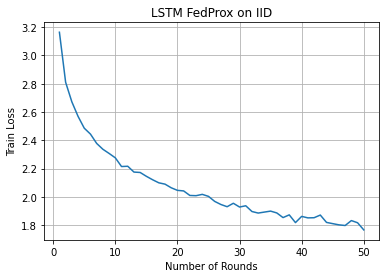

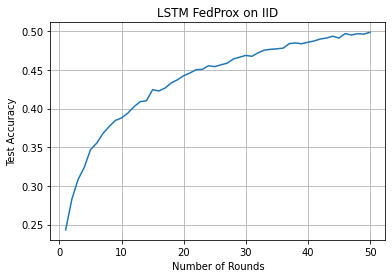

In [36]:
# number of training rounds
rounds = 50
# client fraction
C = 0.07  # 10 clients
# number of clients
K = total_clients
# number of training passes on local dataset for each roung
E = 1
# batch size
batch_size = 10
# learning Rate
lr = 0.8
# proximal term constant
mu = 0.001
# percentage of clients to have fewer than E epochs
percentage = 0
# target test accuracy
target_test_accuracy= 101

shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,  
                                   embedding_dim=embedding_dim,  
                                   hidden_dim=hidden_dim,
                                   classes=num_classes,
                                   lstm_layers=lstm_layers,
                                   dropout=dropout,
                                   batch_first=True
                                   )

if torch.cuda.is_available():
    shakespeare_lstm.cuda()

test_history = []

lstm_iid_trained, test_history = training(shakespeare_lstm,
                                        rounds, batch_size, lr,
                                        train_ds,
                                        data_dict,
                                        test_ds,
                                        C, K, E, mu, percentage,
                                        'LSTM FedProx on IID', "green",
                                        target_test_accuracy,
                                        corpus, # classes
                                        history=test_history,
                                        algorithm='fedavg',
                                        )


final_scores = testing(lstm_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
print(f'\n\n========================================================\n\n')
print(f'Final scores for Exp {run_id} \n {final_scores}')

## LSTM FedProx on Non IID

In [37]:
data_dict, test_ds = noniid_partition(corpus, seq_length=seq_length, val_split=False)
 
total_clients = len(data_dict.keys())  
'Total users:', total_clients

Objective 413629 / 413629


('Total users:', 143)

System heterogeneity set to 0% stragglers.

Picking 7 random clients per round.

Clients: 7/100 -> [88 61 77 96 54 58 24]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)



Round: 1... 	Average Loss: 3.422
running validation...



Test Loss: 3.106199

F1 Score: 0.008108 (macro) 0.077092 (weighted) %


Final Test  Accuracy: 0.203 (20955.0/103477.0)
Clients: 7/100 -> [49 91 36  6 35 80  3]



Round: 2... 	Average Loss: 2.963
running validation...



Test Loss: 2.747405

F1 Score: 0.023729 (macro) 0.163678 (weighted) %


Final Test  Accuracy: 0.264 (27344.0/103477.0)
Clients: 7/100 -> [93 37 82 89 77 54 65]



Round: 3... 	Average Loss: 2.709
running validation...



Test Loss: 2.498689

F1 Score: 0.033840 (macro) 0.201916 (weighted) %


Final Test  Accuracy: 0.298 (30820.0/103477.0)
Clients: 7/100 -> [88 49 21 45 93  9 97]



Round: 4... 	Average Loss: 2.565
running validation...



Test Loss: 2.388723

F1 Score: 0.052344 (macro) 0.254548 (weighted) %


Final Test  Accuracy: 0.333 (34430.0/103477.0)
Clients: 7/100 -> [69 27 65 11 57 33 72]



Round: 5... 	Average Loss: 2.471
running validation...



Test Loss: 2.314104

F1 Score: 0.074170 (macro) 0.295366 (weighted) %


Final Test  Accuracy: 0.355 (36758.0/103477.0)
Clients: 7/100 -> [29 39 42 79  2 18 57]



Round: 6... 	Average Loss: 2.407
running validation...



Test Loss: 2.266206

F1 Score: 0.077990 (macro) 0.304515 (weighted) %


Final Test  Accuracy: 0.368 (38075.0/103477.0)
Clients: 7/100 -> [54 77 64 67 47  1 41]



Round: 7... 	Average Loss: 2.313
running validation...



Test Loss: 2.223298

F1 Score: 0.080392 (macro) 0.311769 (weighted) %


Final Test  Accuracy: 0.369 (38167.0/103477.0)
Clients: 7/100 -> [86 89 63 49 97 20 35]



Round: 8... 	Average Loss: 2.319
running validation...



Test Loss: 2.218300

F1 Score: 0.084250 (macro) 0.322071 (weighted) %


Final Test  Accuracy: 0.372 (38474.0/103477.0)
Clients: 7/100 -> [15 19 12 11 50 35  6]



Round: 9... 	Average Loss: 2.301
running validation...



Test Loss: 2.175351

F1 Score: 0.083916 (macro) 0.327848 (weighted) %


Final Test  Accuracy: 0.379 (39234.0/103477.0)
Clients: 7/100 -> [70 92 18 76 20 58 96]



Round: 10... 	Average Loss: 2.232
running validation...



Test Loss: 2.128791

F1 Score: 0.092425 (macro) 0.329637 (weighted) %


Final Test  Accuracy: 0.389 (40301.0/103477.0)
Clients: 7/100 -> [69 27 55 41 36 80  3]



Round: 11... 	Average Loss: 2.133
running validation...



Test Loss: 2.107105

F1 Score: 0.097210 (macro) 0.339792 (weighted) %


Final Test  Accuracy: 0.393 (40629.0/103477.0)
Clients: 7/100 -> [41 51  4  8 96 11 54]



Round: 12... 	Average Loss: 2.125
running validation...



Test Loss: 2.099010

F1 Score: 0.106658 (macro) 0.348485 (weighted) %


Final Test  Accuracy: 0.399 (41285.0/103477.0)
Clients: 7/100 -> [73 72 68 79 44 37 91]



Round: 13... 	Average Loss: 2.292
running validation...



Test Loss: 2.063465

F1 Score: 0.103259 (macro) 0.356202 (weighted) %


Final Test  Accuracy: 0.408 (42167.0/103477.0)
Clients: 7/100 -> [ 2  0 89 61 91 36 12]



Round: 14... 	Average Loss: 2.151
running validation...



Test Loss: 2.048149

F1 Score: 0.108850 (macro) 0.354932 (weighted) %


Final Test  Accuracy: 0.408 (42219.0/103477.0)
Clients: 7/100 -> [45 22 41 81 71 66 55]



Round: 15... 	Average Loss: 2.104
running validation...



Test Loss: 2.017129

F1 Score: 0.117187 (macro) 0.369450 (weighted) %


Final Test  Accuracy: 0.417 (43166.0/103477.0)
Clients: 7/100 -> [95 51  5 92 93 43 58]



Round: 16... 	Average Loss: 2.08
running validation...



Test Loss: 1.990557

F1 Score: 0.120053 (macro) 0.379234 (weighted) %


Final Test  Accuracy: 0.424 (43877.0/103477.0)
Clients: 7/100 -> [77  7 42 18 47 28 70]



Round: 17... 	Average Loss: 2.018
running validation...



Test Loss: 1.963221

F1 Score: 0.128726 (macro) 0.388226 (weighted) %


Final Test  Accuracy: 0.431 (44580.0/103477.0)
Clients: 7/100 -> [72 32 46 28 47 59 99]



Round: 18... 	Average Loss: 2.016
running validation...



Test Loss: 1.963053

F1 Score: 0.129158 (macro) 0.388892 (weighted) %


Final Test  Accuracy: 0.430 (44485.0/103477.0)
Clients: 7/100 -> [84 75  3 58 95 36 54]



Round: 19... 	Average Loss: 1.993
running validation...



Test Loss: 1.933233

F1 Score: 0.136454 (macro) 0.400058 (weighted) %


Final Test  Accuracy: 0.440 (45507.0/103477.0)
Clients: 7/100 -> [73 21 76  8 81 28 61]



Round: 20... 	Average Loss: 1.92
running validation...



Test Loss: 1.920633

F1 Score: 0.138057 (macro) 0.403115 (weighted) %


Final Test  Accuracy: 0.443 (45842.0/103477.0)
Clients: 7/100 -> [72 42 29  4  3 11 27]



Round: 21... 	Average Loss: 2.057
running validation...



Test Loss: 1.915295

F1 Score: 0.139647 (macro) 0.402948 (weighted) %


Final Test  Accuracy: 0.442 (45686.0/103477.0)
Clients: 7/100 -> [56 47 72 57 87 88 99]



Round: 22... 	Average Loss: 2.018
running validation...



Test Loss: 1.911141

F1 Score: 0.136980 (macro) 0.401396 (weighted) %


Final Test  Accuracy: 0.443 (45842.0/103477.0)
Clients: 7/100 -> [22 78 80 50 24 11 88]



Round: 23... 	Average Loss: 2.003
running validation...



Test Loss: 1.903925

F1 Score: 0.140912 (macro) 0.406342 (weighted) %


Final Test  Accuracy: 0.447 (46215.0/103477.0)
Clients: 7/100 -> [99 89 26 88 57 51  4]



Round: 24... 	Average Loss: 1.918
running validation...



Test Loss: 1.896135

F1 Score: 0.139200 (macro) 0.405274 (weighted) %


Final Test  Accuracy: 0.447 (46215.0/103477.0)
Clients: 7/100 -> [56 83 46 23  3 81 75]



Round: 25... 	Average Loss: 1.846
running validation...



Test Loss: 1.884865

F1 Score: 0.141501 (macro) 0.410001 (weighted) %


Final Test  Accuracy: 0.449 (46414.0/103477.0)
Clients: 7/100 -> [53  4 91 73 15 10  3]



Round: 26... 	Average Loss: 1.892
running validation...



Test Loss: 1.885277

F1 Score: 0.141039 (macro) 0.411417 (weighted) %


Final Test  Accuracy: 0.450 (46523.0/103477.0)
Clients: 7/100 -> [44  7 90 42 91 14 66]



Round: 27... 	Average Loss: 1.915
running validation...



Test Loss: 1.862070

F1 Score: 0.147255 (macro) 0.417572 (weighted) %


Final Test  Accuracy: 0.457 (47322.0/103477.0)
Clients: 7/100 -> [20 96 29 87 73  9 84]



Round: 28... 	Average Loss: 2.08
running validation...



Test Loss: 1.855428

F1 Score: 0.148567 (macro) 0.420149 (weighted) %


Final Test  Accuracy: 0.458 (47384.0/103477.0)
Clients: 7/100 -> [58 41 93 33 56 89 32]



Round: 29... 	Average Loss: 2.029
running validation...



Test Loss: 1.843664

F1 Score: 0.150950 (macro) 0.422877 (weighted) %


Final Test  Accuracy: 0.460 (47610.0/103477.0)
Clients: 7/100 -> [29 14 27 30 65 94 70]



Round: 30... 	Average Loss: 1.938
running validation...



Test Loss: 1.837514

F1 Score: 0.151233 (macro) 0.424267 (weighted) %


Final Test  Accuracy: 0.459 (47474.0/103477.0)
Clients: 7/100 -> [67 82 84 91  5 54 42]



Round: 31... 	Average Loss: 1.832
running validation...



Test Loss: 1.827128

F1 Score: 0.159149 (macro) 0.433678 (weighted) %


Final Test  Accuracy: 0.464 (48053.0/103477.0)
Clients: 7/100 -> [76 68 65 74 32 43  0]



Round: 32... 	Average Loss: 1.874
running validation...



Test Loss: 1.823000

F1 Score: 0.155103 (macro) 0.430713 (weighted) %


Final Test  Accuracy: 0.463 (47930.0/103477.0)
Clients: 7/100 -> [82 69 79 35 91 40 68]



Round: 33... 	Average Loss: 1.927
running validation...



Test Loss: 1.819130

F1 Score: 0.155411 (macro) 0.431273 (weighted) %


Final Test  Accuracy: 0.465 (48137.0/103477.0)
Clients: 7/100 -> [24 49 77 83 58 33 62]



Round: 34... 	Average Loss: 1.679
running validation...



Test Loss: 1.807949

F1 Score: 0.158295 (macro) 0.434726 (weighted) %


Final Test  Accuracy: 0.468 (48432.0/103477.0)
Clients: 7/100 -> [69 64 82 51 37 15 95]



Round: 35... 	Average Loss: 1.883
running validation...



Test Loss: 1.805861

F1 Score: 0.152279 (macro) 0.428667 (weighted) %


Final Test  Accuracy: 0.469 (48500.0/103477.0)
Clients: 7/100 -> [35 10 68 69 80 91 17]



Round: 36... 	Average Loss: 1.808
running validation...



Test Loss: 1.804954

F1 Score: 0.155863 (macro) 0.436819 (weighted) %


Final Test  Accuracy: 0.471 (48725.0/103477.0)
Clients: 7/100 -> [48 98 74 63 53  4 72]



Round: 37... 	Average Loss: 1.815
running validation...



Test Loss: 1.797820

F1 Score: 0.164318 (macro) 0.442021 (weighted) %


Final Test  Accuracy: 0.473 (48965.0/103477.0)
Clients: 7/100 -> [25 64 23 33 67 74 10]



Round: 38... 	Average Loss: 1.791
running validation...



Test Loss: 1.792562

F1 Score: 0.166788 (macro) 0.442988 (weighted) %


Final Test  Accuracy: 0.473 (48929.0/103477.0)
Clients: 7/100 -> [31 46 96 39 32 76 88]



Round: 39... 	Average Loss: 1.867
running validation...



Test Loss: 1.784939

F1 Score: 0.161999 (macro) 0.441803 (weighted) %


Final Test  Accuracy: 0.473 (48938.0/103477.0)
Clients: 7/100 -> [69 15 47 92 25 21 96]



Round: 40... 	Average Loss: 1.74
running validation...



Test Loss: 1.778424

F1 Score: 0.168255 (macro) 0.446397 (weighted) %


Final Test  Accuracy: 0.477 (49393.0/103477.0)
Clients: 7/100 -> [60 96 72 40 59 86 77]



Round: 41... 	Average Loss: 1.782
running validation...



Test Loss: 1.775703

F1 Score: 0.161914 (macro) 0.445457 (weighted) %


Final Test  Accuracy: 0.476 (49250.0/103477.0)
Clients: 7/100 -> [43 42 53 49 21 37 82]



Round: 42... 	Average Loss: 1.767
running validation...



Test Loss: 1.770104

F1 Score: 0.168938 (macro) 0.445833 (weighted) %


Final Test  Accuracy: 0.479 (49566.0/103477.0)
Clients: 7/100 -> [44 77 93 32 53 39 62]



Round: 43... 	Average Loss: 1.761
running validation...



Test Loss: 1.761162

F1 Score: 0.169566 (macro) 0.446920 (weighted) %


Final Test  Accuracy: 0.480 (49702.0/103477.0)
Clients: 7/100 -> [78  6 72 63 95 85 75]



Round: 44... 	Average Loss: 1.878
running validation...



Test Loss: 1.753997

F1 Score: 0.170853 (macro) 0.447885 (weighted) %


Final Test  Accuracy: 0.481 (49815.0/103477.0)
Clients: 7/100 -> [ 7  8  9 63 42 85 88]



Round: 45... 	Average Loss: 1.716
running validation...



Test Loss: 1.744691

F1 Score: 0.176055 (macro) 0.450619 (weighted) %


Final Test  Accuracy: 0.483 (50002.0/103477.0)
Clients: 7/100 -> [79 99 39 17  9 19 13]



Round: 46... 	Average Loss: 1.768
running validation...



Test Loss: 1.741971

F1 Score: 0.172282 (macro) 0.448087 (weighted) %


Final Test  Accuracy: 0.484 (50067.0/103477.0)
Clients: 7/100 -> [19 38 14 77 18 40 39]



Round: 47... 	Average Loss: 1.731
running validation...



Test Loss: 1.743758

F1 Score: 0.171199 (macro) 0.450547 (weighted) %


Final Test  Accuracy: 0.483 (49969.0/103477.0)
Clients: 7/100 -> [13 43  2 82 75 26 70]



Round: 48... 	Average Loss: 1.71
running validation...



Test Loss: 1.725734

F1 Score: 0.176685 (macro) 0.459650 (weighted) %


Final Test  Accuracy: 0.491 (50836.0/103477.0)
Clients: 7/100 -> [ 7 30 20 85 80  3 92]



Round: 49... 	Average Loss: 1.687
running validation...



Test Loss: 1.720954

F1 Score: 0.180835 (macro) 0.460650 (weighted) %


Final Test  Accuracy: 0.491 (50830.0/103477.0)
Clients: 7/100 -> [95 70 97 59 23 71 43]



Round: 50... 	Average Loss: 1.762
running validation...



Test Loss: 1.720779

F1 Score: 0.177347 (macro) 0.458336 (weighted) %


Final Test  Accuracy: 0.491 (50809.0/103477.0)
Training Done! Total time taken to Train: 4508.244726896286
running validation...



Test Loss: 1.720779

F1 Score: 0.177347 (macro) 0.458336 (weighted) %


Final Test  Accuracy: 0.491 (50809.0/103477.0)






NameError: ignored

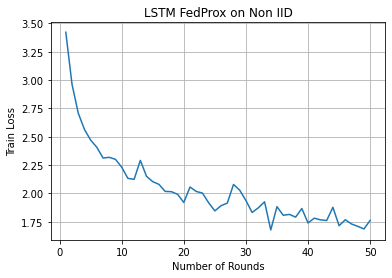

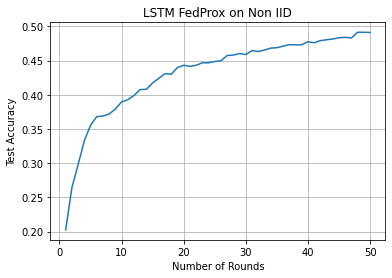

In [38]:
# number of training rounds
rounds = 50
# client fraction
C = 0.07  # 10 clients
# number of clients
K = total_clients
# number of training passes on local dataset for each roung
E = 1
# batch size
batch_size = 10
# learning Rate
lr = 0.8
# proximal term constant
mu = 0.001
# percentage of clients to have fewer than E epochs
percentage = 0
# target test accuracy
target_test_accuracy= 101


shakespeare_lstm = ShakespeareLSTM(input_dim=seq_length,
                                      embedding_dim=embedding_dim,
                                      hidden_dim=hidden_dim,
                                      classes=num_classes,
                                      lstm_layers=lstm_layers,
                                      dropout=dropout,
                                      batch_first=True
                                      )

if torch.cuda.is_available():
    shakespeare_lstm.cuda()

test_history = []

lstm_non_iid_trained, test_history = training(shakespeare_lstm,
                                              rounds, batch_size, lr,
                                              None, #  ds empty as it is included in data_dict
                                              data_dict,
                                              test_ds,
                                              C, K, E, mu, percentage,
                                              'LSTM FedProx on Non IID', "green",
                                              target_test_accuracy,
                                              corpus, # classes
                                              history=test_history,
                                              algorithm='fedavg',
                                              )



final_scores = testing(lstm_non_iid_trained, test_ds, batch_size * 2, nn.CrossEntropyLoss(), len(corpus), corpus)
print(f'\n\n========================================================\n\n')
print(f'Final scores for Exp {run_id} \n {final_scores}')